# Analysis on PGA Data from 2010-2018
Interested in exploring how Profession Golf Association (PGA) Golfers perform.  A dataset from [Kaggle](https://www.kaggle.com/jmpark746/pga-tour-data-2010-2018) covers relevent PGA tour data between 2010-2018.  Let's dive into the data.

#### We will follow the CRISP-DM process throughout this notebook 
1. [Business Understanding](#dm1)<a name="dm1"></a><br>
The following are questions we are interested in answering:<br>
&emsp; ***1. Does the lowest score correlate to making the most money?***<br>
&emsp; ***2. What aspect of the golf game relates most to the highest money made?***<br>
&emsp; ***3. Have golf courses evolved since 2010 leading to different stats contributing differently to success?***<br>
&emsp; ***4. Are those who play more rounds more likely to shoot lower scores?***<br>
2. [Data Understanding](#dm2) <a name="dm2"></a><br>
The data that will be used to answer the above questions is provided entirely within the [Kaggle](https://www.kaggle.com/jmpark746/pga-tour-data-2010-2018) dataset.  This is a fairly comprehensive dataset achieved by the author webscraping [pgatour.com](https://www.pgatour.com/) to access relevent PGA Tour data between 2010-2018.
3. [Data Preparation](#dm3)<br>
&emsp;- [Question 1](#dm31)<br>
&emsp;- [Question 2](#dm32)<br>
&emsp;- [Question 3](#dm33)<br>
&emsp;- [Question 4](#dm34)<br>
4. [Modeling](#dm4)<br>
&emsp;- [Question 1](#dm41) - NO MODEL NECESSARY<br>
&emsp;- [Question 2](#dm42) - NO MODEL NECESSARY<br>
&emsp;- [Question 3](#dm43) - NO MODEL NECESSARY<br>
&emsp;- [Question 4](#dm44) - NO MODEL NECESSARY<br>
5. [Evaluation](#dm5)<br>
&emsp;- [Question 1](#dm51)<br>
&emsp;- [Question 2](#dm52)<br>
&emsp;- [Question 3](#dm53)<br>
&emsp;- [Question 4](#dm54)<br>
6. [Deployment](#dm6)<br>
&emsp;- [Question 1](#dm61)<br>
&emsp;- [Question 2](#dm62)<br>
&emsp;- [Question 3](#dm63)<br>
&emsp;- [Question 4](#dm64)<br>

---

Let's start by importing the necessary libraries and step into preparing the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
import operator
import textwrap
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,10)   # Set larger default size for all plots

# Remove box and ticks on all plots
to_remove = ['axes.spines.left','axes.spines.right','axes.spines.top','axes.spines.bottom',
             'xtick.bottom', 'ytick.left']
for comp in to_remove:
    mpl.rcParams[comp] = False


fg=0  # Start with figure=0 so that figures automatically increment with the code
def figure_incrementer(fig_title, plt_instance, use_incrementer=False, location='top'):
    """Function to increment figures automatically so that when the final notebook has been run, it will
       automatically set the appropriate figure number
       
       inputs:
         fig_title       - should be a string that will be used as figure title.
         plt_instance    - the pyplot instance should be shared here so that the fig_title goes on the
                           correct plot.
         use_incrementer - boolean value to change if you want figure number in the title.
       """
    
    # Increment figure number and set title based on fg number
    global fg
    if use_incrementer:
        fg += 1
        set_title = 'Figure {}: '.format(fg) + fig_title
    else:
        set_title = fig_title
    
    # Set location of the title on the plt_instance
    if location.lower()=='bottom':
        plt_instance.figtext(0.5, 0.01, set_title, wrap=True, horizontalalignment='center', fontsize=14)
    elif location.lower()=='top':
        plt_instance.suptitle(set_title, fontsize=16)
    else:
        raise ValueError('figure_incrementer location must be set to "top" or "bottom"')
        

## Data Preparation <a name="dm3"></a>

The Kaggle dataset is fairly clean but requires some munging to handle NaNs and object columns.

In [2]:
pga = pd.read_csv('./data/pgaTourData.csv')

def clean_df(df):
    """Function that prepares the data for sklearn by removing NaNs"""
    
    # Many of the columns have the same number of NaNs, with this much missing data it doesn't help any predictions. We can drop
    #  these rows if they are missing 12 columns of data
    df = df.dropna(thresh=12)

    # If wins or top10s are NaNs, that means they had 0 for that year
    df.loc[:,['Wins', 'Top 10']] = df.loc[:,['Wins', 'Top 10']].fillna(0)
    
    # There are 4 golfers that have NaNs for points; after investigation, these players did NOT have their PGA Tour card
    #  during the listed year.  It is safe to drop these rows
    df = df.dropna(subset=['Points'])
    
    return df

def transform_df(df):
    """Take the object dtypes and convert into numeric columns"""
    
    # Points is treated as an object because it uses commas as a thousands separator
    df['Points'] = df['Points'].str.replace(',','').astype(np.int64)
    
    # Money uses dollar sign and commas as a thousands separator
    df['Money'] = df['Money'].str.replace(r'\$|,','', regex=True).astype(np.int64)
    df['Money'] = df['Money']/1e6  # turn into Money in Millions of USD
    
    # The Shot Gained: Putts column's name doesn't match similar columns, let's modify that
    df = df.rename({'Average SG Putts': 'SG:PUTT'}, axis=1)
    
    return df

pga = clean_df(pga)
pga = transform_df(pga)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


### Data Preparation: Does the lowest score correlate to making the most money? <a name="dm31"></a>

Both of our first two questions are striving to understand how to make the most money as a PGA Tour professional. Let's start by investigating the distribution of money and score.

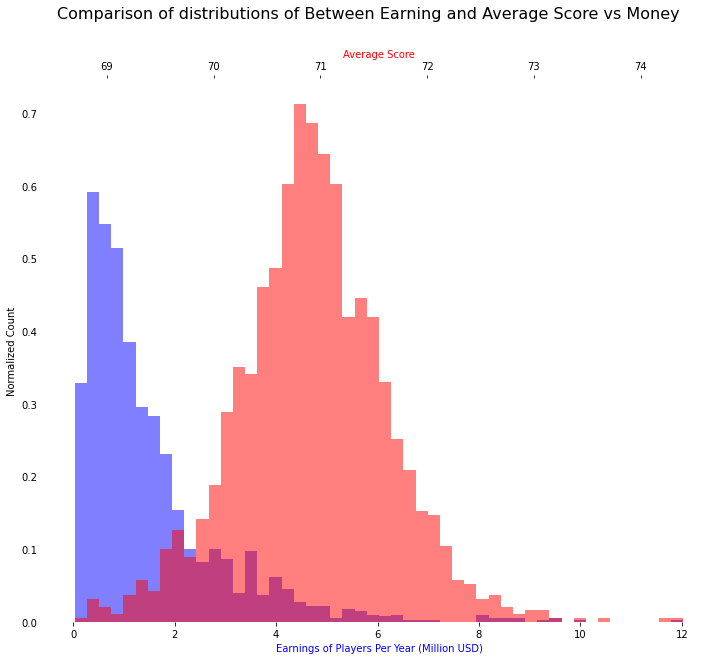

In [3]:
plt.hist(pga.Money, bins=50, alpha=0.5, color='b', density=True)
ax1 = plt.gca()
ax1.set_xlabel('Earnings of Players Per Year (Million USD)', color='b')
ax1.set_ylabel('Normalized Count')

ax2 = ax1.twiny()  # create a second x-axis to view on top of ax1

ax2.hist(pga['Average Score'], bins=50, alpha=0.5, color='r', density=True)
ax2.set_xlabel('Average Score', color='r')

# Set title
title = 'Comparison of distributions of Between Earning and Average Score vs Money'
figure_incrementer(title, plt)

From the histograms, the earnings tends to have a left skew while the scoring seems to be of a normal distribution.  

Let's take a look at the correlation between money and other factors.  We are going to disregard sign when looking at the correlations because golf has a few statistical aspects where it is more beneficial to have a lower number.

In [4]:
print('Correlations to Money:')
pga.drop(['Player Name', 'Year'], axis=1).corr()['Money'].sort_values(key=abs, ascending=False).iloc[1:]

Correlations to Money:


Points                0.949286
Top 10                0.827215
Average SG Total      0.747042
Average Score        -0.746499
Wins                  0.721665
SG:APR                0.510740
SG:OTT                0.441912
Avg Distance          0.329295
Average Scrambling    0.317777
gir                   0.313770
SG:ARG                0.278901
SG:PUTT               0.278895
Rounds                0.278091
Average Putts        -0.257832
Fairway Percentage    0.016237
Name: Money, dtype: float64

This series shows that points are most correlated to money made.  This is not surprising because points are related to finishing position and tournament importance; which also applies to money distributed.  An interesting discovery from this series is that top10s are more correlated to money than wins; however, when we look at average money earned for those players that have at least one win and those that have at least one top10, the potential earning power goes up about 100%.

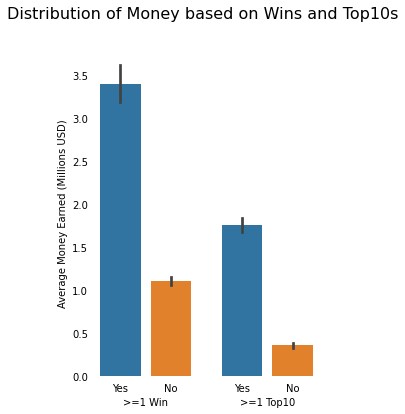

In [5]:
wins = (pga['Wins'] >= 1).replace({True: 'Yes', False: 'No'})
top10 = (pga['Top 10'] >= 1).replace({True: 'Yes', False: 'No'})

fig, axes = plt.subplots(1, 2, figsize=(4,6), sharey=True)
sns.barplot(ax=axes[0], x=wins, y=pga['Money'], order=['Yes','No'])
sns.barplot(ax=axes[1], x=top10, y=pga['Money'])
axes[0].set_ylabel('Average Money Earned (Millions USD)')
axes[0].set_xlabel('>=1 Win')
axes[1].set_ylabel('')
axes[1].set_xlabel('>=1 Top10')

# Set title
title = 'Distribution of Money based on Wins and Top10s'
figure_incrementer(title, plt)

Let's plot the scores vs money on a scatterplot and highlight the winners and top10s. <a name="fig1"></a>

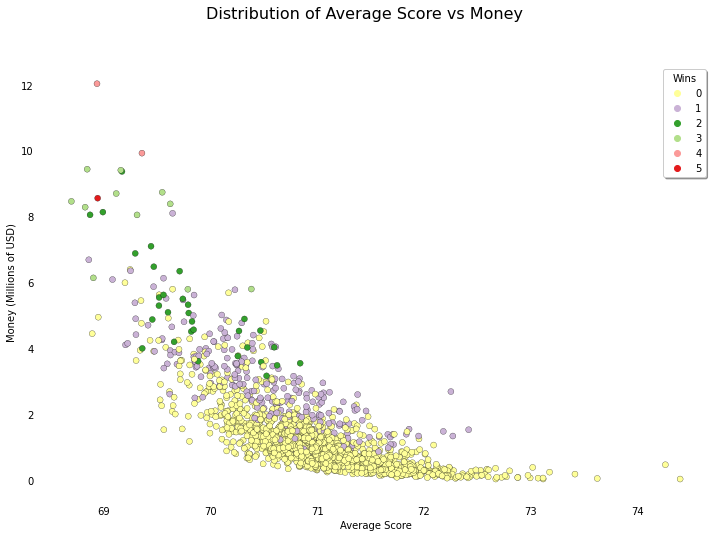

In [6]:
# Select settings
plot_wins = True
plot_top10 = False
# palette = 'Paired'
params = dict(palette='Paired',
              edgecolor='k', 
              linewidth=.25)

# Create dataframe subsets
wins = pga['Wins'].astype(np.int64)
top10 = pga['Top 10'].astype(np.int64)

# Plot based on settings above
if plot_wins & plot_top10:
    fig, axes = plt.subplots(1, 2, figsize=(8,8), sharey=True)
    axes[0].set_ylabel('Money (Millions of USD)')
    sns.scatterplot(ax=axes[0], x=pga['Average Score'], y=pga['Money'], 
                    hue=wins.astype('str'), hue_order=wins.sort_values().astype('str'), **params)
    sns.scatterplot(ax=axes[1], x=pga['Average Score'], y=pga['Money'], 
                    hue=top10.astype('str'), hue_order=top10.sort_values().astype('str'), **params)
    
else:
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.set_ylabel('Money (Millions of USD)')
    if plot_wins:
        sns.scatterplot(x=pga['Average Score'], y=pga['Money'], 
                        hue=wins.astype('str'), hue_order=wins.sort_values().astype('str'), **params)
    elif plot_top10:
        sns.scatterplot(x=pga['Average Score'], y=pga['Money'], 
                        hue=top10.astype('str'), hue_order=top10.sort_values().astype('str'), **params)
    else:
        pass

plt.legend(shadow=True, title='Wins')

# Set title
title = 'Distribution of Average Score vs Money'
figure_incrementer(title, plt)
# plt.suptitle(title, fontsize=16)

In [7]:
sns.crayons.values()

dict_values(['#EFDECD', '#CD9575', '#FDD9B5', '#78DBE2', '#87A96B', '#FFA474', '#FAE7B5', '#9F8170', '#FD7C6E', '#000000', '#1F75FE', '#A2A2D0', '#0D98BA', '#7366BD', '#DE5D83', '#CB4154', '#B4674D', '#FF7F49', '#EA7E5D', '#B0B7C6', '#FFFF99', '#00CC99', '#FFAACC', '#DD4492', '#1DACD6', '#BC5D58', '#DD9475', '#9ACEEB', '#FFBCD9', '#FDDB6D', '#2B6CC4', '#EFCDB8', '#6E5160', '#CEFF1D', '#71BC78', '#6DAE81', '#C364C5', '#CC6666', '#E7C697', '#FCD975', '#A8E4A0', '#95918C', '#1CAC78', '#F0E891', '#FF1DCE', '#B2EC5D', '#5D76CB', '#CA3767', '#3BB08F', '#FEFE22', '#FCB4D5', '#FFBD88', '#F664AF', '#CD4A4C', '#979AAA', '#FF8243', '#C8385A', '#EF98AA', '#FDBCB4', '#1A4876', '#30BA8F', '#1974D2', '#FFA343', '#BAB86C', '#FF7538', '#E6A8D7', '#414A4C', '#FF6E4A', '#1CA9C9', '#FFCFAB', '#C5D0E6', '#FDDDE6', '#158078', '#FC74FD', '#F78FA7', '#8E4585', '#7442C8', '#9D81BA', '#FE4EDA', '#FF496C', '#D68A59', '#FF48D0', '#E3256B', '#EE204D', '#FF5349', '#C0448F', '#1FCECB', '#7851A9', '#FF9BAA', '#FC2847

The plot above shows a potential polynomial (2nd or 3rd order) distribution.  We'll fit a linear model with polynomial features and check the r2score. And then plot the curves on the [distribution figure](#fig1) above.

r2 for 1 order: 	0.5572613412532005
r2 for 2 order: 	0.694037562085124
r2 for 3 order: 	0.7082775375477235


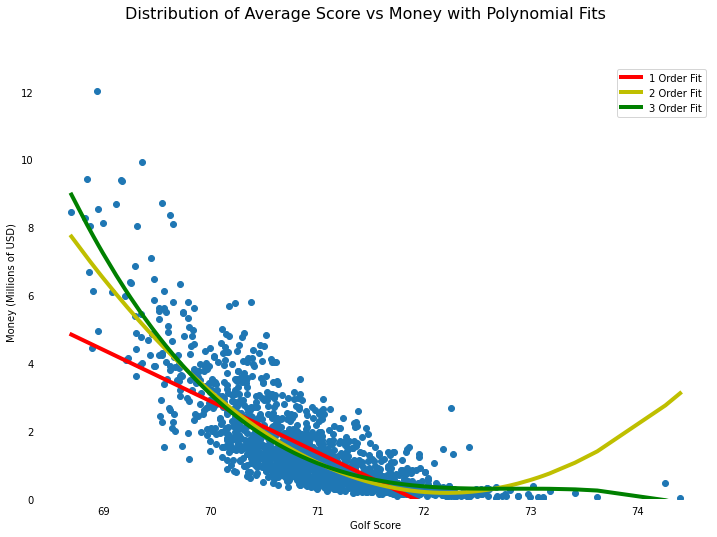

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error

orders = [1, 2, 3]  # Look at linear to 3rd order polynomial fits and compare r2scores
x_data = np.array(pga['Average Score']).reshape(-1,1)
y_data = np.array(pga['Money'])

# Model the data for various order polynomials
y_poly = []
for order in orders:
    model = LinearRegression()
    
    poly = PolynomialFeatures(degree=order)
    x_poly = poly.fit_transform(x_data)
    
    model.fit(x_poly, y_data)
    y_poly.append(model.predict(x_poly))

    r2 = r2_score(y_data, y_poly[-1])
    print('r2 for {} order: \t{}'.format(order, r2))

# Plot curves on top of distribution
plt.figure(figsize=(12,8))
plt.box(False)
plt.grid(True, axis='y')
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.ylabel('Money (Millions of USD)')
plt.scatter(x=pga['Average Score'], y=pga['Money'])

# Sort and plot fits
cols = ['Golf Score'] + ['{} Order Fit'.format(order) for order in orders]

combined_data = np.concatenate((x_data, np.array(y_poly).T), axis=1)
all_df = (pd.DataFrame(combined_data, columns=cols)
            .set_index('Golf Score')
            .sort_index())
ax = plt.gca()
all_df.plot(ax=ax, color=['r', 'y', 'g'], linewidth=4)
plt.ylim(bottom=0)

# Set title
title = 'Distribution of Average Score vs Money with Polynomial Fits'
figure_incrementer(title, plt)

Let's look at a boxplot distribution of money made based on average score

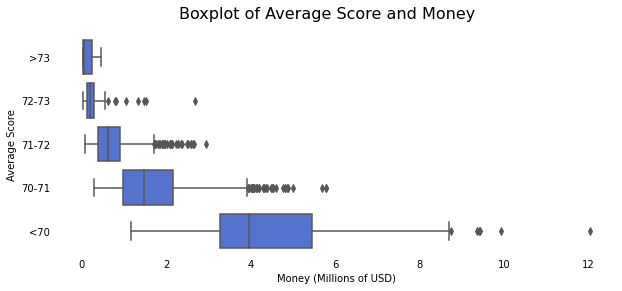

In [9]:
dist_df = pga.loc[:,['Average Score', 'Money']]
labels = ['<70', '70-71', '71-72', '72-73', '>73']
dist_df['Average Score'] = pd.cut(dist_df['Average Score'], bins=[0,70,71,72,73,100], labels=labels)

# Plot data
plt.figure(figsize=(10,4))
labels = labels[-1::-1]
sns.boxplot(y='Average Score', x='Money', data=dist_df, order=labels, color='royalblue')
plt.xlabel('Money (Millions of USD)')

# Set title
title = 'Boxplot of Average Score and Money'
figure_incrementer(title, plt)

Let's look at average score amongst players in various earnings groups

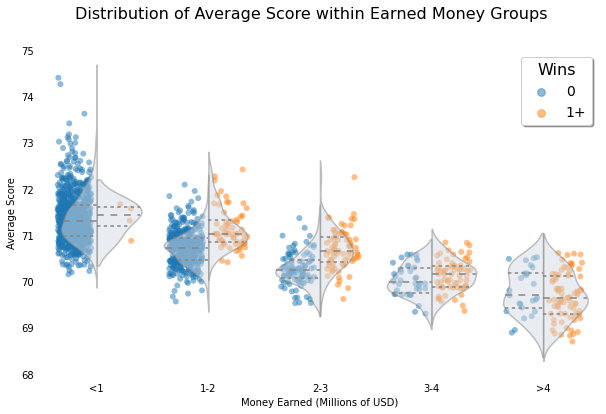

In [10]:
# Create variables for plotting
df = pga.copy()
df['Grouped Money'] = pd.cut(df['Money'], bins=[0,1,2,3,4,20], labels=['<1', '1-2', '2-3', '3-4', '>4'])
top10_labels = ['0','1-5','5-10', '>10']
df['Grouped Top10'] = pd.cut(df['Top 10'], bins=[0,1,5,10,15], labels=top10_labels)
df['WinTF'] = (df['Wins']>0).replace({True: '1+', False: '0'})
df['Top10TF'] = (df['Top 10']>0).replace({True: '1+', False: '0'})

# Plot the data
plt.subplots(1,1, figsize=(10,6))
params = dict(data=df, x='Grouped Money', y='Average Score', hue='WinTF', hue_order=['0', '1+'], dodge=True)
sp = sns.stripplot(size=6, jitter=0.3, edgecolor='k', zorder=0, **params)
vp = sns.violinplot(palette=['#d2d9e5','#d2d9e5'], zorder=10, boxprops=dict(alpha=0.5), inner='quartile', split=True, **params)
plt.xlabel('Money Earned (Millions of USD)')

# Set transparency of violins
[v.set_alpha(0.5) for v in vp.collections]

# Set meaningful legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], shadow=True, title='Wins', title_fontsize=16, fontsize=14, )

# Set title
title = 'Distribution of Average Score within Earned Money Groups'
figure_incrementer(title, plt)

In [11]:
pct = 10
print('Money {}th Percentile: {}'.format((100-pct), np.percentile(pga['Money'], 100-pct)*1e6))
print('Score {}th Percentile: {}'.format((100-pct), np.percentile(pga['Average Score'], pct)))
print('Score {}th Percentile: {}'.format((pct), np.percentile(pga['Average Score'], (100-pct))))


Money 90th Percentile: 3400018.1000000006
Score 90th Percentile: 70.0913
Score 10th Percentile: 71.78540000000001


### Evaluation and Deployment: Does the lowest score correlate to making the most money?<a name="dm51"></a><a name="dm61"></a>
Based on the information contained within the boxplot and helped by other plots above, I'm confident that we can conclude that the lower the score, the more likely money is made.

---

### Data Preparation: What aspect of the golf game relates most to the highest money made? <a name="dm32"></a>

In order to accurately answer the 2nd question, let's revisit the Pearson correlation data only looking at the aspects of the golf game columns.

NOTE: for some good information about the SG (Shots Gained) statistics see this [Medium article](https://medium.com/@jamesmazzolajd/on-strokes-gained-explained-1e92758ef93d)

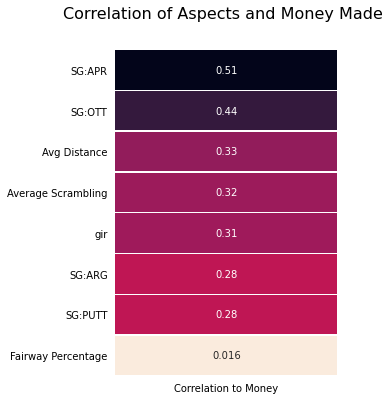

In [23]:
aspect_cols = ['Fairway Percentage', 'Avg Distance','gir', 'Average Scrambling',
               'SG:PUTT', 'SG:OTT', 'SG:APR', 'SG:ARG', 'Money']
correlations = pga[aspect_cols].corr()['Money'].sort_values(ascending=False).to_frame().drop('Money')
correlations.columns = ['Correlation to Money']
plt.figure(figsize=(4,6))
sns.heatmap(correlations, cbar=False, annot=True, linewidths=0.5, cmap="rocket_r")

# Set title
title = 'Correlation of Aspects and Money Made'
figure_incrementer(title, plt)

Now let's look at a scatterplot of all Shot's Gained aspects vs money made:

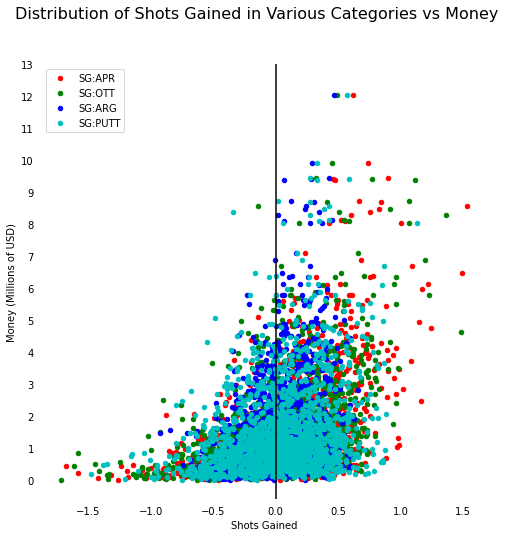

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cols_colors = {'SG:APR': 'r', 'SG:OTT': 'g', 'SG:ARG': 'b', 'SG:PUTT': 'c'}
# [pga.plot(x=x, y='Money', kind='scatter', color=c, ax=ax) for x, c in zip(['SG:APR', 'SG:OTT'], ['r', 'g'])]
[pga.plot(x=x, y='Money', kind='scatter', color=c, ax=ax) for x, c in cols_colors.items()]
plt.legend(['SG:APR', 'SG:OTT', 'SG:ARG', 'SG:PUTT'], loc=2)
plt.ylabel('Money (Millions of USD)')
plt.xlabel('Shots Gained')
# plt.grid(True, axis='y')
plt.yticks(np.arange(0, pga['Money'].max()+1, 1.0))
plt.axvline(x=0.0, c='k')

# Set title
title = 'Distribution of Shots Gained in Various Categories vs Money'
figure_incrementer(title, plt)

The vertical line is drawn at the location of 0.0 Shots Gained which represents an average player in that aspect of the game.  If we focus on the highest earners (>$4 million), the SG:APR (red) and SG:OTT (green) dots appear most to the right of the vertical line.  Those same red and green dots are also more present in the lower left corner of the scatterplot which shows that if you struggle in those areas, you are less likely to make money.

Look at a barplot of a player's best shots gained category and average money made

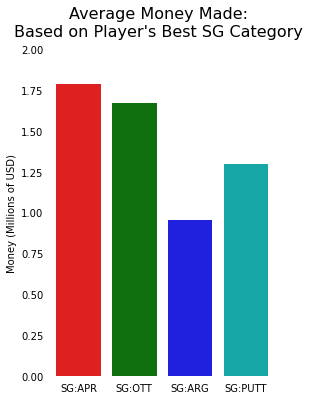

In [54]:
# Create new dataframe for shots gained
cols = ['SG:PUTT', 'SG:OTT', 'SG:APR', 'SG:ARG', 'Money']
sg = pga.loc[:,cols]
sg['best'] = sg.drop('Money', axis=1).idxmax(axis=1)
best_sg = sg.groupby('best').mean().loc[:,'Money']

# Create barplot
p = sns.color_palette('Blues_r', len(best_sg))
rank = best_sg.argsort().argsort()

plt.figure(figsize=(4,6))
# sns.barplot(x=best_sg.index, y=best_sg, palette=np.array(p[::-1])[rank])  # change shade based on prevalence
sns.barplot(x=best_sg.index, y=best_sg, palette=cols_colors, order=cols_colors.keys())  # color same as figure above
plt.ylabel('Money (Millions of USD)')
plt.xlabel('')
plt.ylim((0,2))

# Set title
title = "Average Money Made:\nBased on Player's Best SG Category"
figure_incrementer(title, plt)

Combine the above two plots

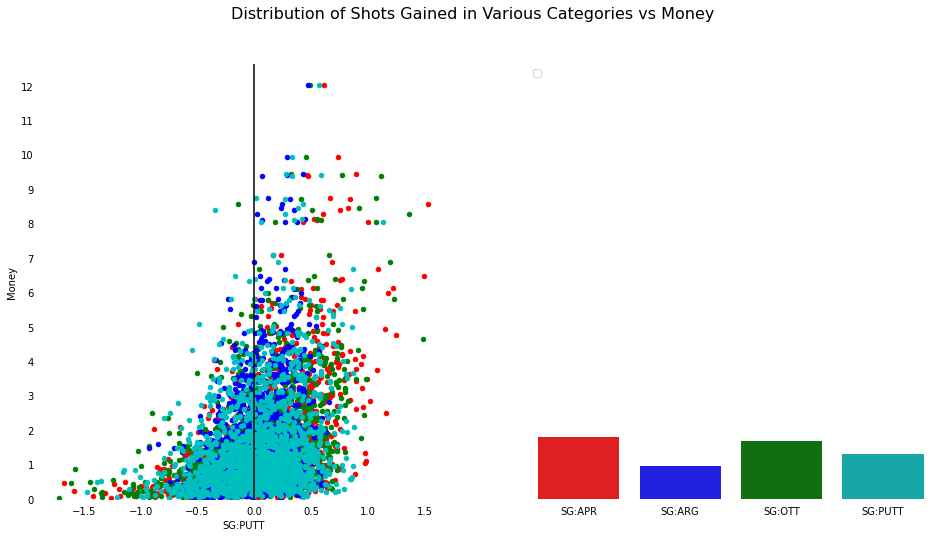

In [51]:
# Define subplots
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True)
cols_colors = {'SG:APR': 'r', 'SG:OTT': 'g', 'SG:ARG': 'b', 'SG:PUTT': 'c'}
[pga.plot(x=x, y='Money', kind='scatter', color=c, ax=axes[0]) for x, c in cols_colors.items()]
plt.legend(['SG:APR', 'SG:OTT', 'SG:ARG', 'SG:PUTT'], loc=2)
plt.ylabel('Money (Millions of USD)')
plt.xlabel('Shots Gained')
plt.yticks(np.arange(0, pga['Money'].max()+1, 1.0))
axes[0].axvline(x=0.0, c='k')

# Create new dataframe for shots gained
cols = ['SG:PUTT', 'SG:OTT', 'SG:APR', 'SG:ARG', 'Money']
sg = pga.loc[:,cols]
sg['best'] = sg.drop('Money', axis=1).idxmax(axis=1)
best_sg = sg.groupby('best').mean().loc[:,'Money']

# Create barplot
sns.barplot(x=best_sg.index, y=best_sg, ax=axes[1], palette=cols_colors)
axes[1].set_ylabel('')
axes[1].set_xlabel('')

# Set title
title = 'Distribution of Shots Gained in Various Categories vs Money'
figure_incrementer(title, plt)

### Evaluation and Deployment: What aspect of the golf game relates most to the highest money made? <a name="dm52"></a><a name="dm62"></a>
We can conclude that the Approach aspect is the most important and Off-the-Tee aspect is next most important in terms of money made as a PGA Tour Professional.  It would be advisable for professionals to focus most of their practice on their approach and off-the-tee games if they want to be most financially successfull.

---

### Data Preparation: Have golf courses evolved since 2010 leading to different stats contributing differently to success?<a name="dm33"></a>

The 3rd question requires us to breakdown each stat aspect to view how they've change over time.

In [14]:
# Select columns we're interested in after grouping
scaled_cols = ['SG:PUTT', 'SG:OTT', 'SG:APR', 'SG:ARG']   # SG are already scaled and ready to directly compare
non_scaled = ['Fairway Percentage', 'Avg Distance', 'gir', 'Average Scrambling', 'Average Score']  # Not already scaled

# Create new df for yearly averages by aspect
pga_yearly = pga.groupby('Year').mean().loc[:,(scaled_cols+non_scaled)]
pga_yearly

,SG:PUTT,SG:OTT,SG:APR,SG:ARG,Fairway Percentage,Avg Distance,gir,Average Scrambling,Average Score
Year,,,,,,,,,
2010,0.008474,0.022089,0.051917,0.004729,63.366979,287.513542,66.908333,58.095781,71.005130
2011,0.034344,0.036280,0.058414,0.012602,61.787473,291.089785,65.520860,57.571075,70.873855
2012,0.017026,0.044463,0.064226,0.015311,61.070211,290.054211,64.911632,57.010158,70.893695
2013,0.028567,0.032622,0.052211,0.011722,61.292000,287.921667,64.991389,57.792722,70.927622
2014,0.013795,0.063653,0.092261,0.028716,61.576761,289.920455,64.975114,58.150625,70.835375
2015,0.011503,0.039749,0.072399,0.028038,61.892350,290.206011,66.288907,58.943443,70.949525
2016,0.021930,0.034103,0.069530,0.023043,60.226216,290.898919,65.556432,58.432703,71.004968
2017,0.038521,0.024179,0.060237,0.027442,60.327895,292.570000,65.350895,58.833158,70.936153
2018,0.053292,0.037917,0.067198,0.030568,61.469740,296.646354,66.409844,58.267135,70.875120


Create a plot of each Shots Gained value and normalized other aspects as they change over time.

Text(0.5, 1.0, 'Time Lapse in Various Golf Aspects vs Money')

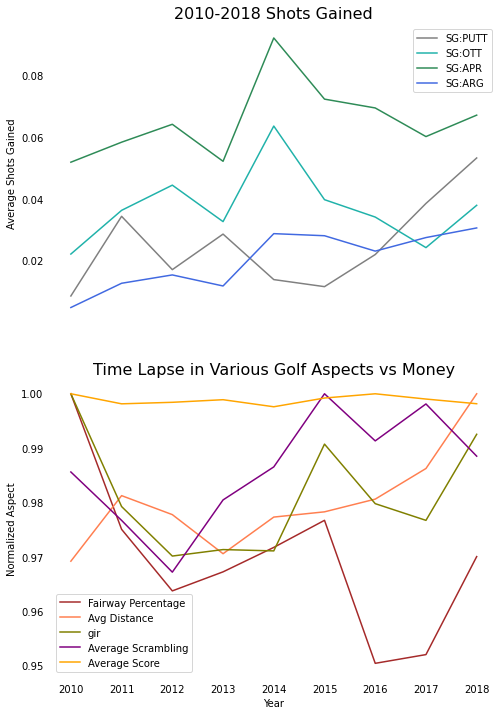

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8,12), sharex=True)

# Plot Shots Gaineds
colors = ['grey', 'lightseagreen', 'seagreen', 'royalblue']
pga_yearly.loc[:,scaled_cols].plot(ax=axes[0], color=colors)
axes[0].set_ylabel('Average Shots Gained')
axes[0].set_title('2010-2018 Shots Gained', fontsize=16)

# Plot normalized other 
colors = ['brown', 'coral', 'olive', 'purple', 'orange']
pga_yearly.loc[:,non_scaled].apply(lambda col: col/col.max(), axis=0).plot(ax=axes[1], color=colors)
axes[1].set_ylabel('Normalized Aspect')
axes[1].set_title('2010-2018 Other Statistics')

# Set title
title = 'Time Lapse in Various Golf Aspects vs Money'
plt.title(title, fontsize=16)
# figure_incrementer(title, plt)

### Evaluation and Deployment: Have golf courses evolved since 2010 leading to different stats contributing differently to success? <a name="dm53"></a><a name="dm63"></a>

The Shots Gained plot of Figure 8 reveals that PGA tour players are aware of the importance of the Approach aspect of the game which shows it leading from 2010-2018 in terms of highest average.  The Off-The-Tee aspect peaked in 2014 but in 2018 dropped back to near 2010 levels.  Putting showed the overall greatest increase which is surprising because it had the lowest correlation to money earned.

The most noticeable aspect of the Other Statistics plot of Figure 8 shows an overall increase in Avg Distance while the Fairway Percentage has decreased.  It would be expected that if driving distance increases, accuracy would decrease but it is difficult to tell if these trends are related to any outside factor such as golf course changes or advancements in technology.

---

### Data Preparation: Are those who play more rounds more likely to shoot lower scores?<a name="dm34"></a> 

This question requires us to start by looking at the correlation between rounds played and average score and compare to other aspects:

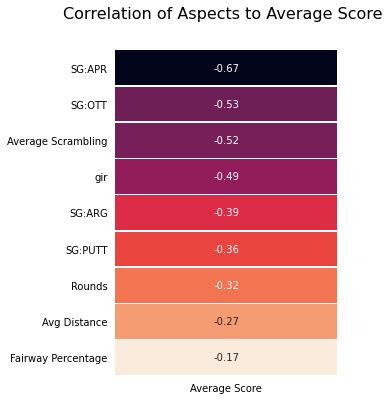

In [16]:
aspect_cols = ['Rounds', 'Fairway Percentage', 'Avg Distance','gir', 'Average Scrambling',
               'SG:PUTT', 'SG:OTT', 'SG:APR', 'SG:ARG', 'Average Score']

# Use absolute value because average score is more likely to be inversely correlated to other variables
correlations = pga[aspect_cols].corr()['Average Score'].sort_values(key=abs, ascending=False).to_frame().drop('Average Score')
plt.figure(figsize=(4,6))
sns.heatmap(correlations, cbar=False, annot=True, linewidths=0.5, cmap="rocket")

# Set title
title = 'Correlation of Aspects to Average Score'
figure_incrementer(title, plt)

There doesn't appear to be a strong correlation between Average Score and Rounds played (at least compared to other factors).  Let's explore if players with wins or top 10s tend to play more rounds: 

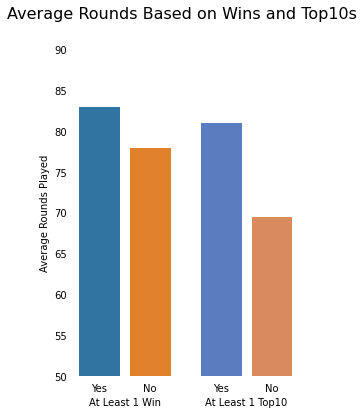

In [17]:
wins = (pga['Wins']>=1).replace({True: 'Yes', False: 'No'})
top10 = (pga['Top 10']>=1).replace({True: 'Yes', False: 'No'})

fig, axes = plt.subplots(1, 2, figsize=(4,6), sharey=True)
sns.barplot(ax=axes[0], x=wins, y=pga['Rounds'], order=['Yes', 'No'], errwidth=0, palette='tab10')
sns.barplot(ax=axes[1], x=top10, y=pga['Rounds'], order=['Yes', 'No'], errwidth=0, palette='muted')

axes[0].set_ylabel('Average Rounds Played')
axes[0].set_xlabel('At Least 1 Win')
axes[1].set_ylabel('')
axes[1].set_xlabel('At Least 1 Top10')

axes[0].set_ylim((50,90))
axes[1].set_ylim((50,90))

# Set title
title = 'Average Rounds Based on Wins and Top10s'
figure_incrementer(title, plt)

After looking at the data, I realized that the results of this plot seem quite obvious.  The more a player plays, the more chance he has to win or place top 10.  This plot doesn't really help our goal of determining if players that play more shoot lower scores on average.  

Let's look at the distribution of rounds played and overlay all yearly averaged scores:

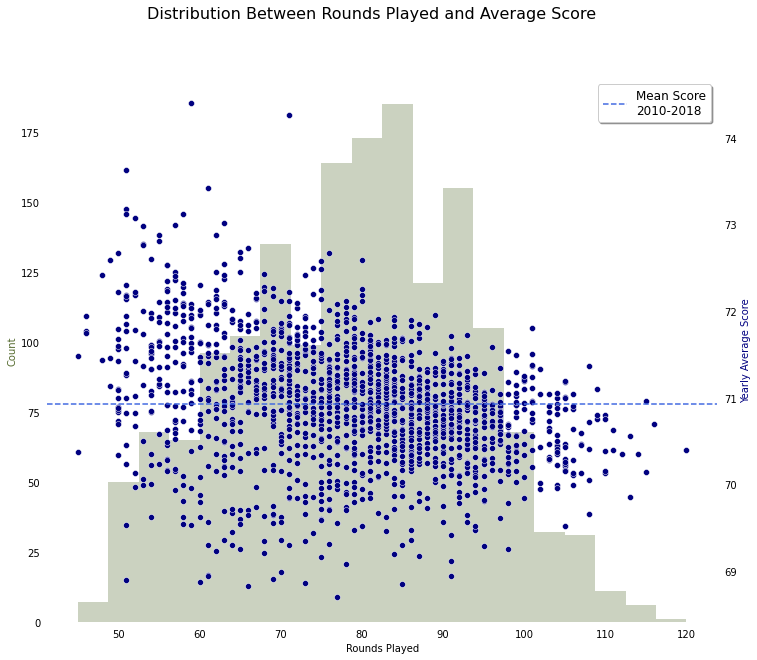

In [18]:
plt.hist(pga['Rounds'], bins=20, alpha=0.3, color='darkolivegreen')
ax1 = plt.gca()
ax1.set_xlabel('Rounds Played')
ax1.set_ylabel('Count', color='darkolivegreen')

# ax2 = ax1.twiny()  # create a second x-axis to view on top of ax1
# ax2.hist(pga['Average Score'], bins=20, alpha=0.5, color='r', density=True)
# ax2.set_xlabel('Average Score', color='r')

ax3 = ax1.twinx()
sns.scatterplot(ax=ax3, x=pga['Rounds'], y=pga['Average Score'], color='navy')
ax3.set_ylabel('Yearly Average Score', color='navy')
ax3.axhline(pga['Average Score'].mean(), linestyle='--', linewidth=1.5, color='royalblue', label='Mean Score\n2010-2018')

ax3.tick_params(axis='both', which='both', bottom=False, left=False, right=False)
ax1.tick_params(axis='both', which='both', bottom=False, left=False, right=False)

plt.legend(fontsize=12, shadow=True)

# Set title
title = 'Distribution Between Rounds Played and Average Score'
figure_incrementer(title, plt)

As expected, Figure 11 seems to indicate a slight decrease in yearly averaged score as the number of rounds increases; however, an interesting discovery is that the more rounds played also contributes to a more consistent lower score.  I would've expected that the 75-85 rounds played region would yield the greatest spread of average score because of the greater count but we might be fighting with the Central Limit Theorem here in that the averaged yearly scores are more likely to collapse to the mean.  

Let's look at this a slightly different way.  Consider a violin plot:

,mean,std
Grouped Rounds,,
<55,71.411762,0.870647
55-65,71.165801,0.904767
65-75,71.037108,0.755515
75-85,70.911692,0.604696
85-95,70.714045,0.489003
95-105,70.638388,0.419416
>105,70.486086,0.380005


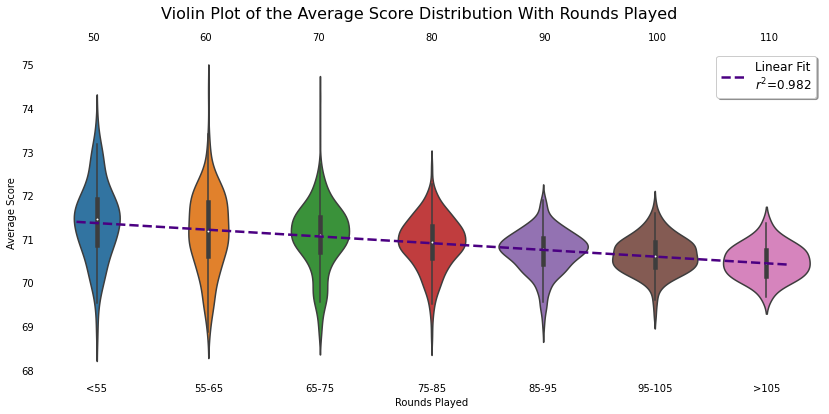

In [57]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Group rounds for violin plot
bplot_df = pga.loc[:,['Rounds', 'Average Score']]
rnd_groups = [0,55,65,75,85,95,105,150]
rnd_group_labels = ['<55', '55-65', '65-75', '75-85', '85-95', '95-105', '>105']
bplot_df['Grouped Rounds'] = pd.cut(bplot_df['Rounds'], bins=rnd_groups, labels=rnd_group_labels)

# Create linear curve fit
xdata = bplot_df['Rounds'].to_numpy()
ydata = bplot_df['Average Score'].to_numpy()
lin_func = lambda x,m,b: m*x+b
lin_fit, _ = curve_fit(lin_func, xdata=xdata, ydata=ydata)

x_line = np.arange(48.5,112)
y_line = lin_func(x_line, lin_fit[0], lin_fit[1])  # for plottting

# Check r2 for lin_fit
x_grps = bplot_df.groupby('Grouped Rounds').mean()['Rounds']
y_grps = bplot_df.groupby('Grouped Rounds').mean()['Average Score']
y_pred = lin_func(x_grps, lin_fit[0], lin_fit[1])
r2 = r2_score(y_grps, y_pred)

# Plot data
plt.figure(figsize=(14,6))
sns.violinplot(x='Grouped Rounds', y='Average Score', data=bplot_df)
plt.ylabel('Average Score')
plt.xlabel('Rounds Played')

ax1 = plt.gca()
ax2 = ax1.twiny()  # create a second x-axis since first one is categorical
ax2.plot(x_line, y_line, linestyle='--', linewidth=2.5, color='indigo', label='Linear Fit\n$r^2$={:.3f}'.format(r2))
# ax2.set_xticklabels([])

ax2.tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False)
ax1.tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False)

plt.legend(fontsize=12, shadow=True)

# Set title
title = 'Violin Plot of the Average Score Distribution With Rounds Played'
figure_incrementer(title, plt)

# bplot_df.groupby('Grouped Rounds').mean()['Average Score']
bplot_df.groupby('Grouped Rounds').agg(['mean', 'std'])['Average Score']

How about rounds to money

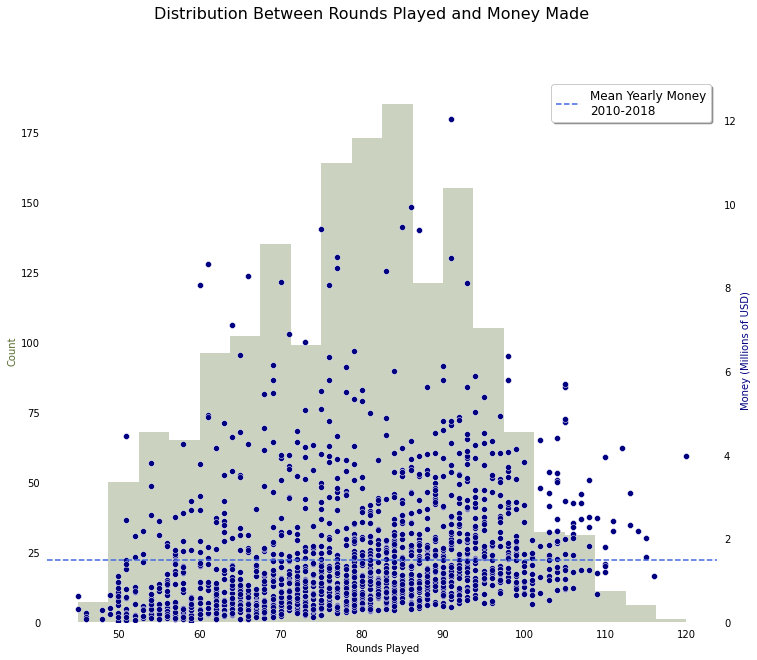

In [63]:
plt.hist(pga['Rounds'], bins=20, alpha=0.3, color='darkolivegreen')
ax1 = plt.gca()
ax1.set_xlabel('Rounds Played')
ax1.set_ylabel('Count', color='darkolivegreen')

# ax2 = ax1.twiny()  # create a second x-axis to view on top of ax1
# ax2.hist(pga['Average Score'], bins=20, alpha=0.5, color='r', density=True)
# ax2.set_xlabel('Average Score', color='r')

ax3 = ax1.twinx()
sns.scatterplot(ax=ax3, x=pga['Rounds'], y=pga['Money'], color='navy')
ax3.set_ylabel('Money (Millions of USD)', color='navy')
ax3.axhline(pga['Money'].mean(), linestyle='--', linewidth=1.5, color='royalblue', label='Mean Yearly Money\n2010-2018')
ax3.set_ylim((0,13))

ax3.tick_params(axis='both', which='both', bottom=False, left=False, right=False)
ax1.tick_params(axis='both', which='both', bottom=False, left=False, right=False)

plt.legend(fontsize=12, shadow=True)

# Set title
title = 'Distribution Between Rounds Played and Money Made'
figure_incrementer(title, plt)

Create barplot underlay instead of histogram on above plot

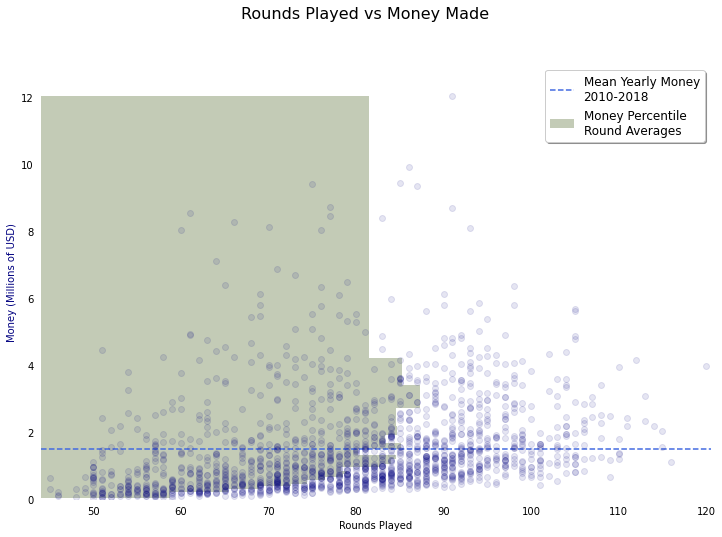

In [144]:
df = pga.loc[:,['Money','Rounds']]

# Break up into Money percentiles
buckets = [np.percentile(pga['Money'], pct) for pct in np.arange(0,101,5)]
df['money_grp'] = pd.cut(pga['Money'], bins=buckets, include_lowest=True)

# Create df of rounds average across the money groups (aka heights of barplot)
heights = df.groupby('money_grp').mean().loc[:,'Rounds']

# Create barplot variables
widths = [buckets[i+1]-buckets[i] for i in range(len(buckets)-1)]
x_pos = [np.mean([buckets[i+1],buckets[i]]) for i in range(len(buckets)-1)]

# Initialize figure
fig, ax = plt.subplots(1,1, figsize=(12,8))

# Create barplot
ax.barh(y=x_pos, height=widths, width=heights, alpha=0.35, color='darkolivegreen', zorder=1, label='Money Percentile\nRound Averages')

# Create scatterplot
ax.scatter(x=pga['Rounds'], y=pga['Money'], color='navy', alpha=0.1, zorder=5)
ax.set_ylabel('Money (Millions of USD)', color='navy')
ax.axhline(pga['Money'].mean(), linestyle='--', linewidth=1.5, color='royalblue', label='Mean Yearly Money\n2010-2018')
ax.set_ylim((0,13))
ax.set_xlim((44,120.5))
ax.set_xlabel('Rounds Played')

plt.legend(fontsize=12, shadow=True)

# Set title
title = 'Rounds Played vs Money Made'
figure_incrementer(title, plt)

,mean,std
Grouped Rounds,,
<55,0.655806,0.798554
55-65,1.034194,1.310300
65-75,1.275038,1.441721
75-85,1.510466,1.379411
85-95,1.885118,1.495977
95-105,1.989524,1.214191
>105,2.140060,0.891915


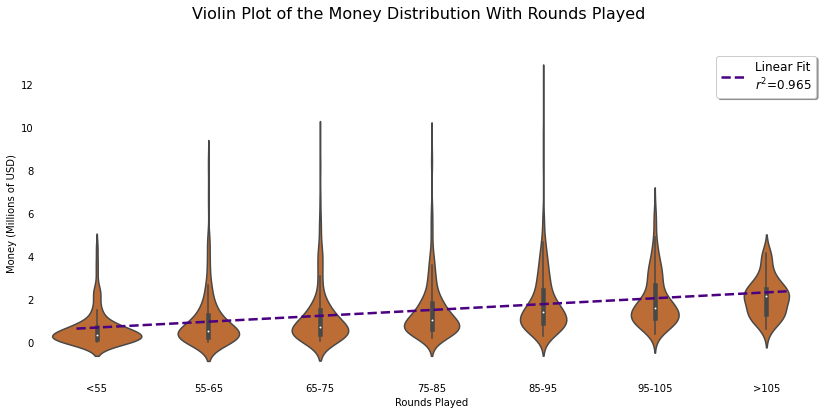

In [148]:
# Group rounds for violin plot
bplot_df = pga.loc[:,['Rounds', 'Money']]
rnd_groups = [0,55,65,75,85,95,105,150]
rnd_group_labels = ['<55', '55-65', '65-75', '75-85', '85-95', '95-105', '>105']
bplot_df['Grouped Rounds'] = pd.cut(bplot_df['Rounds'], bins=rnd_groups, labels=rnd_group_labels)

# Create linear curve fit
xdata = bplot_df['Rounds'].to_numpy()
ydata = bplot_df['Money'].to_numpy()
lin_func = lambda x,m,b: m*x+b
lin_fit, _ = curve_fit(lin_func, xdata=xdata, ydata=ydata)

x_line = np.arange(48.5,112)
y_line = lin_func(x_line, lin_fit[0], lin_fit[1])  # for plottting

# Check r2 for lin_fit
x_grps = bplot_df.groupby('Grouped Rounds').mean()['Rounds']
y_grps = bplot_df.groupby('Grouped Rounds').mean()['Money']
y_pred = lin_func(x_grps, lin_fit[0], lin_fit[1])
r2 = r2_score(y_grps, y_pred)

# Plot data
plt.figure(figsize=(14,6))
sns.violinplot(x='Grouped Rounds', y='Money', data=bplot_df, color='chocolate')
# sns.swarmplot(x='Grouped Rounds', y='Money', data=bplot_df, color='chocolate', alpha=0.1)
plt.ylabel('Money (Millions of USD)')
plt.xlabel('Rounds Played')

ax1 = plt.gca()
ax2 = ax1.twiny()  # create a second x-axis since first one is categorical
ax2.plot(x_line, y_line, linestyle='--', linewidth=2.5, color='indigo', label='Linear Fit\n$r^2$={:.3f}'.format(r2))
ax2.set_xticklabels([])
# sns.scatterplot(x='Rounds', y='Money', data=bplot_df, ax=ax2)

ax2.tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False)
ax1.tick_params(axis='both', which='both', bottom=False, left=False, right=False, top=False)

plt.legend(fontsize=12, shadow=True)

# Set title
title = 'Violin Plot of the Money Distribution With Rounds Played'
figure_incrementer(title, plt)

# bplot_df.groupby('Grouped Rounds').mean()['Average Score']
bplot_df.groupby('Grouped Rounds').agg(['mean', 'std'])['Money']

In [80]:
top_rnds = np.percentile(pga['Rounds'], 98)
top_mony = np.percentile(pga['Money'], 98)
tops = pga[(pga['Rounds']>top_rnds) & (pga['Money']>top_mony)]
tops.describe()

,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,SG:PUTT,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Evaluation and Deployment: Are those who play more rounds more likely to shoot lower scores? <a name="dm54"></a><a name="dm64"></a>

It appears that the number of rounds a player plays contributes approximately one full stroke on average between the group with the most rounds and group with the least.  It is almost a perfect negative linear relationship between rounds played and average score.  The number of rounds does not keep a player from averaging a really low score but it helps maintain a consistent low score.

---

## Code below is additional exploration that doesn't directly relate to any of our business questions and possibly to use for future exploration

To explore our Explore correlations.  We'll start by removing columns that display the same data as other columns; this will help simplify the analysis and prevent data leakage if machine learning algorithms are going to be used later.  To find the columns that we want to remove, let's view a heatmap of the correlations.

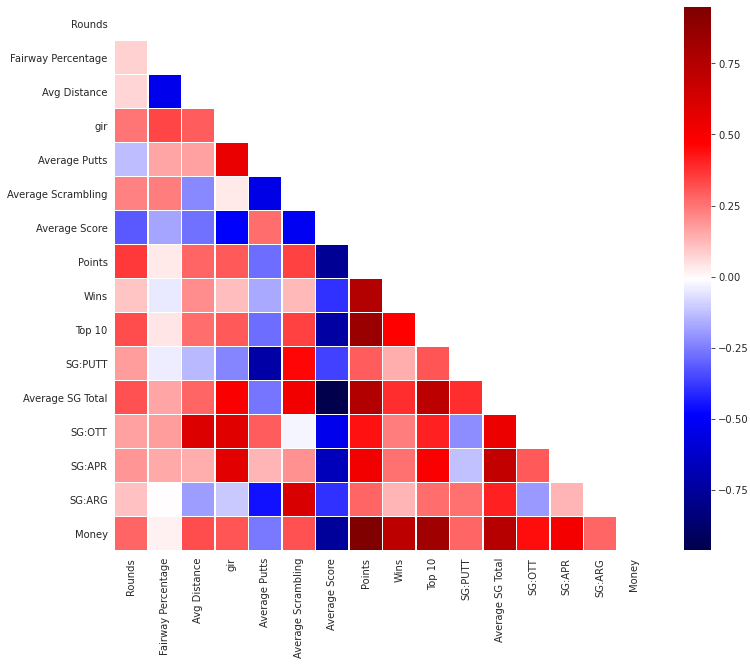

In [20]:
# Removing Player Name and Year from the dataframe first then perform a global Pearson correlation
correlations = pga.drop(['Player Name', 'Year'], axis=1).corr()
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots()
    ax = sns.heatmap(correlations, mask=mask, linewidths=0.5, cmap='seismic')

We used a diverging colormap above because some aspects of golf are perfectly negatively correlated (i.e. the lower the score, the better the round and more likely to win)

Break up the dataframes by year.  Potentially interested in using 2010-2017 data to predict 2018 data.

In [21]:
pga_years = [pga[pga['Year']==year] for year in sorted(pga['Year'].unique())]